<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right">Mihailo Kolundzija, <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, Lucie Perrotta, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">Dithering and Noise Shaping</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
import scipy.signal as signal
import IPython.display as ipd
import ipywidgets as ipw
import scipy.io.wavfile as wavfile
from stft_helpers import stft_window, stft

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

In [3]:
def multiplay(SF, clips, title=None, volume=1):
    outs = [ipw.Output() for c in clips]
    for ix, clip in enumerate(clips):
        with outs[ix]:
            print(title[ix] if title is not None else "")
            display(ipd.Audio(volume * clip, rate=SF, normalize=False))
    return ipw.HBox(outs)

# Quantization recap


## Uniform scalar quantization

 * $M$-level uniform scalar quantizer: $q: \mathbb{R} \rightarrow \{\hat{x}_0, \ldots, \hat{x}_{M-1}\}$
 * non-overload region: $[-1,1]$
 * quantization step: $\Delta = 2/M$ 
 * usually $M = 2^R$; quantization with $R$ bits per sample


Uniform quantizer types:
 * **Mid-tread** (deadzone): $\displaystyle\quad q(x) = \left\lfloor \frac{x + 0.5}{\Delta} \right\rfloor $
 * **Mid-rise**: $\displaystyle\quad q(x) = \left\lfloor \frac{x}{\Delta} \right\rfloor + \frac{\Delta}{2} $


In [4]:
def quantize(x, M):
    if M == 0:
        return x
    elif M % 2 == 0:
        # using a mid-rise quantizer
        M = M / 2
        k = np.floor(x * M)
        k = np.maximum(np.minimum(k, M-1), -M)
        return (k + 0.5) / M
    else:
        # using a deadzone quantizer
        k = np.round(np.abs(x) * M / 2)
        k = np.minimum((M - 1) / 2, k)
        return (np.sign(x) * k / M * 2 )

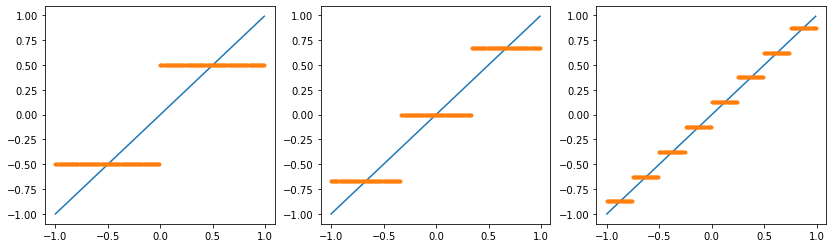

In [5]:
x = np.arange(-1, 1, .01)
for ix, M in enumerate([2, 3, 8]):
    plt.subplot(1, 3, ix+1)
    plt.plot(x,x);    
    plt.plot(x, quantize(x, M), '.');

## Conventional quantization theory
 
Quantization is a lossy operation:
 - **Quantization error** $e[n] = q(x[n]) - x[n]$
 - $e[n]$ **uniformly distributed random variable** over $[-\Delta/2,\Delta/2)$, independent of input
 - $e$ a **white noise process** with zero mean and variance $\sigma_e^2 = \Delta^2/12$

Signal-to-Noise Ratio (SNR):
 - if input iid and uniform over non-overload region: $\text{SNR} = 6.02 R ~\text{dB}$
 - if input full-range sinusoid: $\text{SNR} = 6.02 b + 1.76 ~\text{dB}$
 - every bit increases SNR by 6 dB

## The truth: quantization causes _distortion_ not noise

 * classical model useful as a guideline but fails in many cases (Tsividis paradox)
 * harmonic and non-harmonic distortion much more disruptive than noise

## Quantization distortion demo

In [6]:
# The influence of the number of quantization steps on the quantization error.

# Sampling frequency in Hz.
fs = 44100
# Signal duration in seconds.
duration = 5

# Number of samples for which we plot the time-domain signals.
nt = 600
# Regularization constant to avoid taking a log of zero.
mu = 1e-6

# Define the widgets to control the demo parameters.
win_type_dd_1 = ipw.Dropdown(options=['rect', 'hanning', 'hamming'],
                           value='hanning', description='Window type',
                           disabled=False)

fft_size_dd_1 = ipw.Dropdown(options=[256, 512, 1024, 2048, 4096, 8192, 16384],
                           value=4096, description='FFT size',
                           disabled=False)

a_db_fs_1 = ipw.FloatSlider(
    min=-96, max=0, step=-3, value=-6, description='$a$ [dB]')
f_fs_1 = ipw.FloatSlider(
    min=100, max=5000, step=10, value=440, description='$f_0$')
nbits_is_1 = ipw.IntSlider(
    min=1, max=24, step=1, value=10, description='$n_{\it bits}$')

demo_out_1 = ipw.Output()

default_layout = ipw.Layout(
    border='solid 1px black',
    margin='0px 10px 10px 0px',
    padding='5px 5px 5px 5px')

def update_no_dither(a, f, nbits, win_type='rect', fft_size=4096):
    t = np.arange(0, duration, 1/fs)
    x = a * np.sin(2 * np.pi * f * t + 1)
    step_size = 2 / 2**nbits
    
    # Prepare the windowing function.
    win = stft_window(fft_size, fft_size, win_type=win_type)
    # Work with a 50% overlap.
    hop_size = fft_size // 2
    
    y = quantize(x, 2**nbits)
    e = x - y
    
    # Create ideal noise power reference.
    noise_ref = (np.random.random(len(t)) - 0.5) * step_size 
    
    # Compute the spectra of y and e by averaging the STFT magnitude.
    _, f_n, Y_s = stft(y, win, hop_size)
    _, _, E_s = stft(e, win, hop_size)
    _, _, R_s = stft(noise_ref, win, hop_size)
    Y = np.mean(np.abs(Y_s), axis=1)
    E = np.mean(np.abs(E_s), axis=1)
    R = np.mean(np.abs(R_s), axis=1)
    # Convert normalized to absolute frequencies.
    freqs = f_n * fs
    
    e_mean = np.mean(e)
    
    e_pow_theory = step_size**2 / 12
    e_pow = np.mean(e**2)
    x_pow = np.mean(x**2)

    snr_theory = 20 * np.log10(2) * nbits + 10 * np.log10(1.5) + 20 * np.log10(a)
    snr = 10 * np.log10(x_pow / e_pow) 
    
    # Extreme value for plotted vertical lines giving harmonics.
    Y_max = 20 * np.log10(np.max(np.abs(Y)))
    Y_min = 20 * np.log10(np.min(np.abs(Y)) + mu)
    E_max = 20 * np.log10(np.max(np.abs(E)))
    E_min = 20 * np.log10(np.min(np.abs(E)) + mu)
    R_max = 20 * np.log10(np.max(np.abs(R)))
    R_min = 20 * np.log10(np.min(np.abs(R)) + mu)
    # Since we're plotting the theoretical noise PSD, account for it.
    Y_max = np.maximum(Y_max, R_max)
    Y_min = np.minimum(Y_min, R_min)
    E_max = np.maximum(E_max, R_max)
    E_min = np.minimum(E_min, R_min)
    
    # Harmonics of the sinusoidal signal to show on plot.
    harmonics = np.arange(f, fs/2, f)
    
    out_text_0 = ipw.Output()
    out_text_0.layout = default_layout
    out_text_1 = ipw.Output()
    out_text_1.layout = default_layout
    
    with out_text_0:
        print('Quantization step size:            {:.4E}'.format(step_size))
        print('Quantization error power (theory): {:.4E}'.format(e_pow_theory))
        print('Quantization error power:          {:.4E}'.format(e_pow))
    with out_text_1:
        print('SNR (theory): {:.4f} dB'.format(snr_theory))
        print('SNR:          {:.4f} dB'.format(snr))
        
    audio_out_0 = ipw.Output()
    audio_out_1 = ipw.Output()
    audio_out_2 = ipw.Output()
    
    with audio_out_0:
        print('Original')
        display(ipd.Audio(data=np.clip(x, -1, 1), rate=fs, normalize=False))
    with audio_out_1:
        print('Quantized')
        display(ipd.Audio(data=np.clip(y, -1, 1), rate=fs, normalize=False))
    with audio_out_2:
        print('Quantization error')
        display(ipd.Audio(data=np.clip(e, -1, 1), rate=fs, normalize=False))
    
    text_group = ipw.HBox([out_text_0, out_text_1])
    audio_group = ipw.HBox([audio_out_0, audio_out_1, audio_out_2])
    audio_group.layout = default_layout
    
    demo_out_1.clear_output()
    
    figure_out = ipw.Output()
    figure_out.layout = default_layout
    with figure_out:
        plt.figure(figsize=(15, 6))

        plt.subplot(2, 2, 1)
        plt.plot(t[:nt], y[:nt], color='b')
        plt.xlabel('t [s]')
        plt.title('Quantizer output $y$')
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.plot(t[:nt], e[:nt], color='b')
        plt.xlabel('t [s]')
        plt.title('Quantization error $e$')
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.vlines(harmonics, Y_min, Y_max, label='$f_0$ harmonics', 
                   colors='yellow', linestyles='dashed')
        plt.plot(freqs, 20 * np.log10(np.abs(Y)+mu), 
                 color='b', label='$Y(f)$')
        plt.plot(freqs, 20 * np.log10(np.abs(R)+mu), 
                 color='red', label='$Ref. noise PSD$')
        plt.xlabel('f [Hz]')
        plt.title('Spectrum $Y(f)$ of the quantized signal')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.vlines(harmonics, E_min, E_max, label='$f_0$ harmonics', 
                   color='yellow', linestyles='dashed')
        plt.plot(freqs, 20 * np.log10(np.abs(E)+mu), 
                 color='b', label='$E(f)$')
        plt.plot(freqs, 20 * np.log10(np.abs(R)+mu), 
                 color='red', label='$Ref. noise PSD$')
        plt.xlabel('f [Hz]')
        plt.title('Spectrum $E(f)$ of the quantization error')
        plt.legend()
        plt.grid()

        plt.tight_layout()

        plt.show()
    
    with demo_out_1:
        display(text_group)
        display(audio_group)
        display(figure_out)
        
def click_no_dither(change):
    update_no_dither(a=10**(a_db_fs_1.value/20),
                     f=f_fs_1.value,
                     nbits=nbits_is_1.value,
                     win_type=win_type_dd_1.value, 
                     fft_size=fft_size_dd_1.value)

# Group widgets to have the desired looks.
sliders_1 = ipw.HBox([a_db_fs_1, f_fs_1, nbits_is_1])
sliders_1.layout = default_layout
dropdowns_1 = ipw.HBox([win_type_dd_1, fft_size_dd_1])
dropdowns_1.layout = default_layout
controls_1 = ipw.VBox([sliders_1, dropdowns_1])
controls_1.layout = default_layout
run_button_1 = ipw.Button(description='Run')
run_button_1.on_click(click_no_dither)

In [7]:
display(ipw.VBox([controls_1, run_button_1, demo_out_1]))
click_no_dither(None)

# Dithering

<img width="600" style="float: right;" src="img/mark1.jpg">

During WWII, mecahnical computers were used for navigation and targeting. 

They appeared to be more precise when operated in flying aircraft.

The vibrations smmothed out the motion of the mechanical gears and improved the results.

Vibration units (dithering) were thus built into the machines themselves

## Dithered quantization

Main idea:
 * add noise to the quantization process to make the error look like noise
 * price to pay: a lower SNR
 * hoped-for gain: trade distortion for noise

Two types of dithering:

<img src="img/quantizer_dither.png" width=800>

## Subtractively dithered quantizers

 - Add dither $\nu$ prior to quantization, remove exact same $\nu$ at decoder
 - Decoder must be able to reproduce the same dither: clearly impractical

Of theoretical interest nonetheless:
 * dither samples drawn from $\mathcal{U}\left(-\Delta/2,\Delta/2 \right)$ make the error white and independent of input
 * $\sigma_e^2 = \Delta^2/12$, as in the idealized case

## Non-subtractively dithered quantizers
<img width="300" style="float: right;" src="img/tpdf.png">

 * dither is **not** subtracted at the decoder, which lowers the SNR
 * error can **not** be made independent of input
 
  
Fundamental result: if dither is drawn from a triangular PDF (TPDF) over $[-\Delta,\Delta)$:
 * error is zero-mean
 * $\sigma_e^2 = \Delta^2/4$, **independent** of $x$
 * $e[n]$ is not iid but it is a **white process**
 
Sadly, proof is very technical; see [here](http://robertwannamaker.com/writings/ieee.pdf) for details.

### Non-iid white noise?

A white noise process $\eta[n]$ is characterized by
 * $\mathrm{E}[\eta[n]] = 0$ 
 * $\mathrm{E}[\eta[n]\eta[m]] = \delta[n-m] \sigma_\eta^2$ 
 
Zero correlation implies there is no _linear_ relationship between samples, but nonlinear dependencies may exist

Example: two fair coins, A and B
 * toss coins A and B
 * if coin A at _previous_ step was heads, output zero
 * else 
   * if A is tails, output zero
   * else 
     * if B is heads output 1, else -1 
     
The process can be modeled as $z[n] = y[n]x[n](1 - x[n-1])$ where $x[n] \sim \text{Bernoulli}(0.5)$ and $y[n] \sim \text{Rademacher}$, independent.

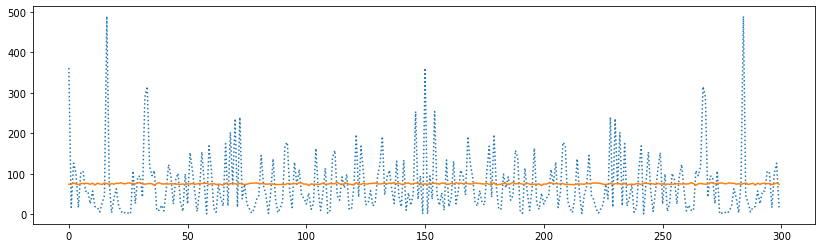

In [8]:
def toy_noise(N):
    x = np.round(np.random.random(N))
    y = 2 * (np.round(np.random.random(N)) - .5)
    return x * (1 - np.roll(x, -1)) * y

N, M = 300, 3000
# plot DFT of single realization for reference
psd = np.abs(np.fft.fft(toy_noise(N))) ** 2
plt.plot(psd, ':')
# now average a few realizations for the PSD
for n in range(1, M):
    psd = psd + np.abs(np.fft.fft(toy_noise(N))) ** 2
plt.plot(psd / M);

**Exercise:** prove that the process is not iid but that the spectrum is white

### How to generate a triangular pdf

Remember that the pdf of the sum of two r.v. is the convolution of the pdf's.

In [9]:
def tpdf(levels, n):
    a = (np.random.random(n) - 0.5) * (2 / levels)
    b = (np.random.random(n) - 0.5) * (2 / levels)
    return a + b

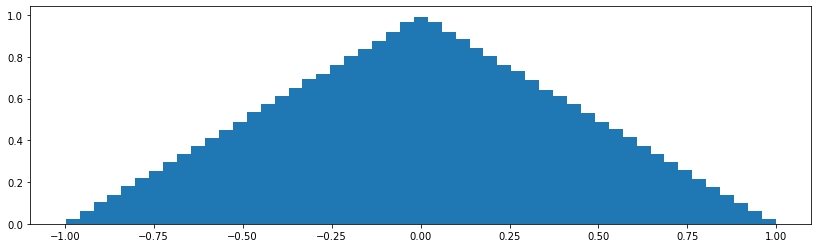

In [10]:
plt.hist(tpdf(2, 1000000), bins=51, density=True);

## Dithered quantization demo

In [11]:
# What happens when we add the subtractive dither into the picture.

# Sampling frequency in Hz.
fs = 44100
# Signal duration in seconds.
duration = 4

# Number of samples for which we plot the time-domain signals.
nt = 600
# Regularization constant to avoid taking a log of zero.
mu = 1e-6

# Define the widgets to control the demo parameters.
dither_opt_dd_2 = ipw.Dropdown(
    options=['no', 'subtractive', 'non-subtractive'],
    value='no', description='Dither: ', disabled=False)

win_type_dd_2 = ipw.Dropdown(
    options=['rect', 'hanning', 'hamming'],
    value='hanning', description='Window type',
    disabled=False)

fft_size_dd_2 = ipw.Dropdown(
    options=[256, 512, 1024, 2048, 4096, 8192, 16384],
    value=4096, description='FFT size',
    disabled=False)

a_fs_2 = ipw.FloatSlider(
    min=0, max=1, step=0.001, value=0.5, description='$a$')
f_fs_2 = ipw.FloatSlider(
    min=100, max=5000, step=10, value=440, description='$f_0$')
nbits_is_2 = ipw.IntSlider(
    min=1, max=24, step=1, value=10, description='$n_{\it bits}$')

demo_out_2 = ipw.Output()

default_layout = ipw.Layout(
    border='solid 1px black',
    margin='0px 10px 10px 0px',
    padding='5px 5px 5px 5px')

def update_dither(
    a, f, nbits, 
    dither_opt='no', 
    win_type='rect', fft_size=4096):
    
    t = np.arange(0, duration, 1/fs)
    x = a * np.sin(2 * np.pi * f * t + 1)
    levels = 2 ** nbits
    step_size = 2 / levels
    
    # Prepare the windowing function.
    win = stft_window(fft_size, fft_size, win_type=win_type)
    # Work with a 50% overlap.
    hop_size = fft_size // 2
    
    d = tpdf(levels, len(t))
    snr_reduction = 10 * np.log10(3)
    e_pow_mul_increase = 3
    
    snr_theory = 20 * np.log10(2) * nbits + 10 * np.log10(1.5)
    # Correct for signal's amplitude.
    snr_theory += 20 * np.log10(a)
    e_pow_theory = step_size**2 / 12
    
    if dither_opt.lower() == 'no':
        y = quantize(x, levels)
    elif dither_opt.lower() == 'subtractive':
        e_pow_mul_increase = 1
        y = quantize(x + d, levels) - d
    elif dither_opt.lower() == 'non-subtractive':
        y = quantize(x + d, levels)
        snr_theory -= snr_reduction
        e_pow_theory *= e_pow_mul_increase
    else:
        raise ValueError('Unknown dithering subtraction scheme')
    
    # Create uniform dither to serve as the ideal noise power reference.
    d_rpdf = (np.random.random(len(t)) - 0.5) * step_size
        
    e = y - x
    
    # Compute the spectra of the quantizer's output and error.
    _, f_n, Y_s = stft(y, win, hop_size)
    _, _, E_s = stft(e, win, hop_size)
    _, _, D_s = stft(d, win, hop_size)
    _, _, R_s = stft(d_rpdf, win, hop_size)
    Y = np.mean(np.abs(Y_s), axis=1)
    E = np.mean(np.abs(E_s), axis=1)
    D = np.mean(np.abs(D_s), axis=1)
    R = np.mean(np.abs(R_s), axis=1)
    # Convert normalized to absolute frequencies.
    freqs = f_n * fs
    
    # Compute the stats.
    e_mean = np.mean(e)
    e_pow = np.mean(e**2)
    d_pow = np.mean(d**2)
    x_pow = np.mean(x**2)
    r_pow = np.mean(d_rpdf**2)

    snr = 10 * np.log10(x_pow / e_pow)
    
    # Extreme value for plotted vertical lines showing harmonics.
    Y_max = 20 * np.log10(np.max(np.abs(Y)))
    Y_min = 20 * np.log10(np.min(np.abs(Y)) + mu)
    E_max = 20 * np.log10(np.max(np.abs(E)))
    E_min = 20 * np.log10(np.min(np.abs(E)) + mu)
    R_max = 20 * np.log10(np.max(np.abs(R)))
    R_min = 20 * np.log10(np.min(np.abs(R)) + mu)
    # Since we're plotting the theoretical noise PSD, account for them.
    Y_max = np.maximum(Y_max, R_max)
    Y_min = np.minimum(Y_min, R_min)
    E_max = np.maximum(E_max, R_max)
    E_min = np.minimum(E_min, R_min)
    
    # Harmonics of the sinusoid's frequency to show on plots.
    harmonics = np.arange(f, fs/2, f)
    
    out_text_0 = ipw.Output()
    out_text_0.layout = default_layout
    out_text_1 = ipw.Output()
    out_text_1.layout = default_layout
    
    with out_text_0:
        print('Quantization step size: {:.4E}'.format(step_size))
        print('Noise power (theory):   {:.4E}'.format(e_pow_theory))
        print('Noise power:            {:.4E}'.format(e_pow))
    with out_text_1:
        print('Dither power: {:.4E}'.format(d_pow))
        print('SNR (theory): {:.4f} dB'.format(snr_theory))
        print('SNR:          {:.4f} dB'.format(snr))
        
    audio_out_0 = ipw.Output()
    audio_out_1 = ipw.Output()
    audio_out_2 = ipw.Output()
    
    with audio_out_0:
        print('Original')
        display(ipd.Audio(data=np.clip(x, -1, 1), 
                              rate=fs, normalize=False))
    with audio_out_1:
        print('Quantized')
        display(ipd.Audio(data=np.clip(y, -1, 1), 
                              rate=fs, normalize=False))
    with audio_out_2:
        print('Quantization error')
        display(ipd.Audio(data=np.clip(e, -1, 1), rate=fs, normalize=False))
    
    text_group = ipw.HBox([out_text_0, out_text_1])
    audio_group = ipw.HBox([audio_out_0, audio_out_1, audio_out_2])
    audio_group.layout = default_layout
    
    demo_out_2.clear_output()
    
    figure_out = ipw.Output()
    figure_out.layout = default_layout

    with figure_out:
        plt.figure(figsize=(15, 6))

        plt.subplot(2, 2, 1)
        plt.plot(t[:nt], y[:nt], color='b')
        plt.ylim([-1.1, 1.1])
        plt.title('Quantizer\'s output')
        plt.ylabel('$y(t)$')
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.plot(t[:nt], e[:nt], color='b')
        plt.xlabel('$t$ [s]')
        plt.ylabel('$e(t)$')
        plt.title('Quantization error')
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.vlines(harmonics, Y_min, Y_max, label='$f_0$ harmonics', 
                   colors='yellow', linestyles='dashed')
        plt.plot(freqs, 20 * np.log10(np.abs(Y)+mu), 
                 color='blue', label='$Y(f)$')
        plt.plot(freqs, 20 * np.log10(np.abs(R)+mu), 
                 color='red', label='$Ref. noise PSD$')
        plt.ylabel('$Y(f)$ [dB]')
        plt.title('Quantized signal\'s spectrum')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.vlines(harmonics, E_min, E_max, label='$f_0$ harmonics', 
                   color='yellow', linestyles='dashed')
        plt.plot(freqs, 20 * np.log10(np.abs(E)+mu), 
                 color='blue', label='$E(f)$')
        plt.plot(freqs, 20 * np.log10(np.abs(R)+mu), 
                 color='red', label='$Ref. noise PSD$')
        plt.ylabel('$E(f)$ [dB]')
        plt.xlabel('$f$ [Hz]')
        plt.title('Quantization error\'s spectrum')
        plt.legend()
        plt.grid()

        plt.tight_layout()

        plt.show()
        
    with demo_out_2:
        display(text_group)
        display(audio_group)
        display(figure_out)

def click_dither(change):
    update_dither(
        a=a_fs_2.value, f=f_fs_2.value,
        nbits=nbits_is_2.value,
        dither_opt=dither_opt_dd_2.value, 
        win_type=win_type_dd_2.value,
        fft_size=fft_size_dd_2.value)

# Group widgets to have the desired looks.
sliders_2 = ipw.HBox([a_fs_2, f_fs_2, nbits_is_2])
sliders_2.layout = default_layout
dropdowns0_2 = ipw.HBox([dither_opt_dd_2, win_type_dd_2, fft_size_dd_2]) 
dropdowns_2 = ipw.VBox([dropdowns0_2]) 
dropdowns_2.layout = default_layout
controls_2 = ipw.VBox([sliders_2, dropdowns_2])
controls_2.layout = default_layout
run_button_2 = ipw.Button(description='Run')
run_button_2.on_click(click_dither)

In [12]:
display(ipw.VBox([controls_2, run_button_2, demo_out_2]))
click_dither(None)

## A closer look in the time domain

In [13]:
def quantize_dither(x, M):
    return quantize(x + tpdf(M, len(x)), M)

In [14]:
%%capture out

pts = 1000
x = 0.6 * np.sin(2 * np.pi * np.linspace(0.1, 1.5, pts))

M = 4
qx = [quantize(x, M), quantize_dither(x, M)]

a, delay, gain = 0.99, 80, 1.1
fqx = [gain * signal.lfilter([1 - a], [1, -a], y)[delay:] for y in qx ]

fig, ax = plt.subplots(2, figsize=(13,7))
ax[0].set_title("quantization without dither");
ax[1].set_title("quantization with dither");

for n in (0, 1):
    ax[n].plot(x[:-delay], label="original signal")
    ax[n].plot(qx[n][:-delay], label="quantized signal", drawstyle="steps-pre", alpha=0.7)
    ax[n].plot(fqx[n], label="filtered quantized signal")
    ax[n].legend(loc="lower right")
    ax[n].get_xaxis().set_visible(False)

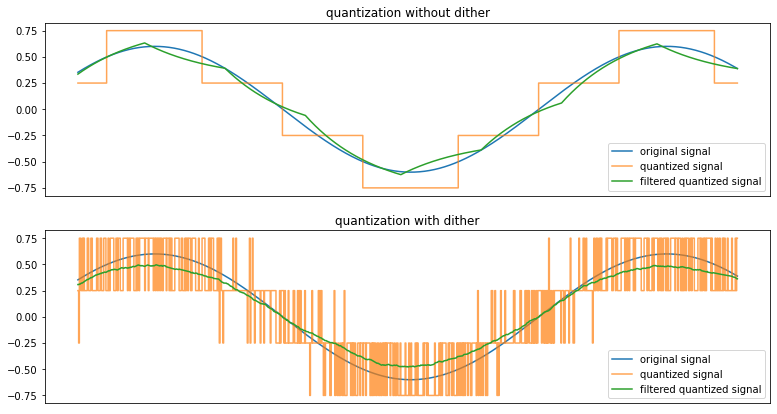

In [15]:
out.show();

## Requantizing the Bolero

Let's repeat the requantization experiment with the initial part of Bolero, this time with dithering:

In [16]:
clips = {}
for name in ['boleroA',]:
    sf, audio = wavfile.read('snd/' + name + '.wav')
    clips['sf'], clips[name] = sf, audio / 32767.0

multiplay(clips['sf'], 
          [quantize(clips['boleroA'], 2 ** 16), quantize(clips['boleroA'], 2 ** 8), quantize_dither(clips['boleroA'], 2 ** 8)], 
          ['16 bits', '8 bits, no dithering', '8 bits, dithering'])

# Noise shaping

<img src="img/nsdq.png"  width="400" style="float: right; margin: 0 30px 0;">

Recap for non-subtractive dither with triangular dither PDF:
 * error dependent on input but white PSD
 * $P_e(\omega) = \sigma_e^2 = \Delta^2/4$

## Feeding back the error
<img src="img/quantizer_noise_shape.png" width=400 style="float: right; margin: 0 30px 0;">

 * $x'[n]$ input to dithering quantizer $Q$
 * error $e[n] = y[n] - x'[n]$ 
 * $x'[n] = x[n] - (h \ast e)[n]$
 * $Y(z) = X(z) + (1 - H(z))E(z)$

Quantization error is now a **filtered** white noise process with PSD

$$
   P_e(\omega) = (\Delta^2/4)\, |1-H(e^{j\omega})|^2
$$

### Filters specifications

Requirements for realizability:
 * $H(z)$ causal
 * $h[0] = 0$, i.e. at least one-step delay in the feedback path 

Goal:
 * make the noise less _audible_ perceptually

### Perceptual noise shaping
<img src="https://upload.wikimedia.org/wikipedia/commons/4/49/Lindos4.svg" width=360 style="float: right;">

Human auditory system exhibits a frequency-dependent sensitivity, as per experimental ([equal loudness contours](https://en.wikipedia.org/wiki/Equal-loudness_contour)).

 * $W(e^{j\omega})$ : approximate $15$-phon equal loudness contour
 * optimal filter: $|1-H(e^{j\omega})|^2 = \frac{w}{W(e^{j\omega})} $
 
Remarks: 
 * attenuating the noise in some frequency bands will inevitably amplify it at others
 * the total quantization noise power with a noise shaping filter will always increase compared to no noise shaping
 * as long as the noise is less audible, we're good

Simple FIR approximation to the inverse of the 15-phon curve, as found [in Lipshitz's seminal paper](http://www2.ece.rochester.edu/courses/ECE472/Site/Assignments/Entries/2009/1/15_Week_1_files/Lipshitz_1991.pdf)

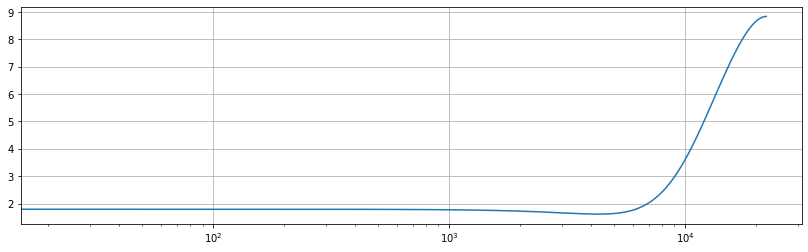

In [17]:
PTS = 1024
plt.semilogx(np.linspace(0, 22050, PTS), 20 * np.log10(np.abs(np.fft.fft([1.726, -0.7678, 0.2709], 2 * PTS)[:PTS])))
plt.grid()

## Example: dithered quantization with noise shaping

In [18]:
def quantize_ns(x, M, dither, b_h, a_h):
    a_h = np.append(a_h, 0) if len(a_h) == 1 else a_h
    y = np.zeros(x.shape)
    x_i = np.zeros(len(b_h))
    y_i = np.zeros(len(a_h)-1)
    for i, s in enumerate(x):
        h_o = (np.dot(x_i, b_h) - np.dot(y_i, a_h[1:])) / a_h[0]
        s_d = s - h_o
        y[i] = quantize(s_d + dither[i], M)
        e = y[i] - s_d
        x_i = np.append(e, x_i[0:-1])
        y_i = np.append(h_o, y_i[0:-1])
    return y

In [21]:
# Sampling frequency in Hz.
fs = 44100
# Signal duration in seconds.
duration = 4

# Number of samples for which we plot the time-domain signals.
nt = 600
# Regularization constant to avoid taking a log of zero.
mu = 1e-6

# Define the noise shaping filter. From Lipschitz's paper, filter #5
a_h = np.array([1])
b_h = np.array([1.726, -0.7678, 0.2709])

# Define the widgets to control the demo parameters.
win_type_dd_5 = ipw.Dropdown(options=['rect', 'hanning', 'hamming'],
    value='hanning', description='Window type',
    disabled=False)

fft_size_dd_5 = ipw.Dropdown(
    options=[256, 512, 1024, 2048, 4096, 8192, 16384],
    value=4096, description='FFT size',
    disabled=False)

a_fs_5 = ipw.FloatSlider(
    min=0, max=1, step=0.001, value=0.5, description='$a$')

f_fs_5 = ipw.FloatSlider(
    min=100, max=5000, step=10, value=1500, description='$f_0$')

nbits_is_5 = ipw.IntSlider(
    min=1, max=24, step=1, value=4, description='$n_{\it bits}$')

demo_out_5 = ipw.Output()

default_layout = ipw.Layout(
    border='solid 1px black',
    margin='0px 10px 10px 0px',
    padding='5px 5px 5px 5px')

def update_ns_dither(
    a, f, T, fs, nbits, 
    win_type='rect', fft_size=4096):
    
    t = np.arange(0, T, 1/fs)
    x = a * np.sin(2 * np.pi * f * t)
    step_size = 2 / 2**nbits
    
    # Prepare the windowing function.
    win = stft_window(fft_size, fft_size, win_type=win_type)
    # Work with a 50% overlap.
    hop_size = fft_size // 2
    
    d = tpdf(2**nbits, len(t))
    e_pow_theory = step_size**2 / 4

    y_nns = quantize_dither(x, 2**nbits)
    #plt.plot(y_nns)
    y_ns = quantize_ns(x, 2**nbits, d, b_h, a_h)
    e_ns = y_ns - x
    e_nns = y_nns - x

    # Compute the quantized signal's spectrum.
    _, f_n, Y_ns_s = stft(y_ns, win, hop_size)
    Y_ns = np.mean(np.abs(Y_ns_s), axis=1)
    _, _, Y_nns_s = stft(y_nns, win, hop_size)
    Y_nns = np.mean(np.abs(Y_nns_s), axis=1)
    # Compute the error spectra.
    _, _, E_ns_s = stft(e_ns, win, hop_size)
    E_ns = np.mean(np.abs(E_ns_s), axis=1)
    _, _, E_nns_s = stft(e_nns, win, hop_size)
    E_nns = np.mean(np.abs(E_nns_s), axis=1)
    
    freqs = f_n * fs
    
    # Extreme value for plotted vertical lines showing harmonics.
    Y_max = 20 * np.log10(np.max(np.abs(Y_ns)))
    Y_min = 20 * np.log10(np.min(np.abs(Y_ns)) + mu)
    E_max = 20 * np.log10(np.max(np.abs(E_ns)))
    E_min = 20 * np.log10(np.min(np.abs(E_ns)) + mu)
    # Since we're plotting the theoretical noise PSD, account for them.
    Y_max = np.maximum(Y_max, 10*np.log10(e_pow_theory*fft_size))
    Y_min = np.minimum(Y_min, 10*np.log10(e_pow_theory*fft_size))
    E_max = np.maximum(E_max, 10*np.log10(e_pow_theory*fft_size))
    E_min = np.minimum(E_min, 10*np.log10(e_pow_theory*fft_size))
    
    audio_out_0 = ipw.Output()
    audio_out_1 = ipw.Output()
    audio_out_2 = ipw.Output()
    
    with audio_out_0:
        print('Original')
        display(ipd.Audio(data=np.clip(x, -1, 1), rate=fs, normalize=False))
    with audio_out_1:
        print('Quantized w/ dither')
        display(ipd.Audio(data=np.clip(y_nns, -1, 1), rate=fs, normalize=False))
    with audio_out_2:
        print('Quantized w/ dither and noise shaping')
        display(ipd.Audio(data=np.clip(y_ns, -1, 1), rate=fs, normalize=False))
        
    audio_group = ipw.HBox([audio_out_0, audio_out_1, audio_out_2])
    audio_group.layout = default_layout
    
    demo_out_5.clear_output()
    
    figure_out = ipw.Output()
    figure_out.layout = default_layout

    with figure_out:
        plt.figure(figsize=(15, 6))

        plt.subplot(2, 2, 1)
        plt.plot(t[:nt], y_ns[:nt], color='b')
        plt.ylabel('$y(t)$')
        plt.title('Quantizer\'s output with noise shaping', fontsize=12)
        plt.ylim([-1.1, 1.1])
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.plot(t[:nt], e_ns[:nt], color='b')
        plt.xlabel('$t$ [s]')
        plt.ylabel('$e(t)$')
        plt.title('Quantization error with noise shaping', fontsize=12)
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.plot(freqs, 20*np.log10(np.abs(Y_ns)+mu), color='blue', label='w/ NS')
        plt.plot(freqs, 20*np.log10(np.abs(Y_nns)+mu), color='green', label='w/o NS')
        plt.ylabel('$Y(f)$ [dB]')
        plt.title('Quantized signal\'s spectrum')
        plt.legend()
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.plot(freqs, 20*np.log10(np.abs(E_ns)+mu), 
                 color='blue', label='w/ NS')
        plt.plot(freqs, 20*np.log10(np.abs(E_nns)+mu),
                 color='green', label='w/o NS')
        plt.xlabel('$f$ [H]')
        plt.ylabel('$E(f)$ [dB]')
        plt.title('Quantization error\'s spectrum')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
        
    with demo_out_5:
        display(audio_group)
        display(figure_out)
        
def click_ns_dither(change):
    update_ns_dither(
        a=a_fs_5.value, f=f_fs_5.value,
        nbits=nbits_is_5.value,
        T=duration, fs=fs,
        win_type=win_type_dd_5.value, 
        fft_size=fft_size_dd_5.value)

# Group widgets to have the desired looks.
sliders_5 = ipw.HBox([a_fs_5, f_fs_5, nbits_is_5])
sliders_5.layout = default_layout
dropdowns1_5 = ipw.HBox([win_type_dd_5, fft_size_dd_5])
dropdowns_5 = ipw.VBox([dropdowns1_5])
dropdowns_5.layout = default_layout
controls_5 = ipw.VBox([sliders_5, dropdowns_5])
controls_5.layout = default_layout
run_button_5 = ipw.Button(description='Run')
run_button_5.on_click(click_ns_dither)

In [22]:
display(ipw.VBox([controls_5, run_button_5, demo_out_5]))
click_ns_dither(None)